# IBM Applied Data Science Capstone
### Week 5 Final notebook
**Opening a New Movie Theater in Denver, Colorado**
- Build a dataframe of neighborhoods in Denver, Colorado by web scraping the data from Wikipedia page
- Get the geographical coordinates of the neighborhoods
- Obtain the venue data for the neighborhoods from Foursquare API
- Explore and cluster the neighborhoods
- Select the best cluster to open a new movie theater
***
### 1. Import libraries

In [179]:
# Install necessary libraries
#!pip install geopy
#!pip install geocoder
#!pip install folium

In [180]:
# Vectorize data in n-dimensional arrays
import numpy as np 

# import pandas for dataframe analysis
import pandas as pd 
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# handle JSON files
import json 

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 
import geocoder

# handle requests
import requests

# parse HTML and XML documents
from bs4 import BeautifulSoup 

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering
import folium 

print("Libraries imported.")

Libraries imported.


### 2. Web Scrape data from Wikipedia page into a DataFrame

In [181]:
# send the GET request
data = requests.get("https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Denver").text

In [182]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [183]:
# create a list to store neighborhood data
neighborhoodList = []

In [184]:
# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text)

In [185]:
# create a new DataFrame from the list
denver_df = pd.DataFrame({"Neighborhood": neighborhoodList})

denver_df.head()

,Neighborhood
0,List of neighborhoods in Denver
1,"Alamo Placita, Denver"
2,"Athmar Park, Denver"
3,"Auraria, Denver"
4,"Baker, Denver"


In [186]:
# print the number of rows of the dataframe
denver_df.shape

(52, 1)

In [187]:
denver_df.describe

<bound method NDFrame.describe of                            Neighborhood
0       List of neighborhoods in Denver
1                 Alamo Placita, Denver
2                   Athmar Park, Denver
3                       Auraria, Denver
4                         Baker, Denver
5                        Barnum, Denver
6                       Belcaro, Denver
7                      Berkeley, Denver
8                  Capitol Hill, Denver
9                  Central Park, Denver
10                 Chaffee Park, Denver
11                Cheesman Park, Denver
12                 Cherry Creek, Denver
13                    Chinatown, Denver
14               City Park West, Denver
15                    City Park, Denver
16  Civic Center, Denver (neighborhood)
17                      Clayton, Denver
18                         Cole, Denver
19                Congress Park, Denver
20                 Country Club, Denver
21                      Downtown Denver
22               Elyria-Swansea, Denver
23    

In [188]:
denver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Neighborhood  52 non-null     object
dtypes: object(1)
memory usage: 544.0+ bytes


### 3. Get geographical coordinates

In [189]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Denver, Colorado'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [190]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in denver_df["Neighborhood"].tolist() ]

In [191]:
coords

[[39.74308700000006, -104.97893599999998],
 [39.721070000000054, -104.97521999999998],
 [39.70396000000005, -105.01038999999997],
 [39.745750000000044, -105.00996999999995],
 [39.71117000000004, -104.99208999999996],
 [39.71816000000007, -105.03261999999995],
 [39.70384000000007, -104.94973999999996],
 [39.77666000000005, -105.03956999999997],
 [39.733700000000056, -104.97956999999997],
 [39.76013000000006, -104.87849999999997],
 [39.78741000000008, -105.01755999999995],
 [39.72911000000005, -104.96816999999999],
 [39.717820000000074, -104.94872999999995],
 [39.74001000000004, -104.99201999999997],
 [39.74545000000006, -104.96719999999999],
 [39.74379000000005, -104.94824999999997],
 [39.73526000000004, -104.99057999999997],
 [39.76693000000006, -104.95050999999995],
 [39.76633000000004, -104.96593999999999],
 [39.73359000000005, -104.95000999999996],
 [39.721960000000024, -104.96551999999997],
 [39.74822000000006, -104.99412999999998],
 [39.781960000000026, -104.95909999999998],
 [39.

In [192]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [193]:
# merge the coordinates into the original dataframe
denver_df['Latitude'] = df_coords['Latitude']
denver_df['Longitude'] = df_coords['Longitude']

In [194]:
# check the neighborhoods and the coordinates
print(denver_df.shape)
denver_df

(52, 3)


,Neighborhood,Latitude,Longitude
0,List of neighborhoods in Denver,39.743087,-104.978936
1,"Alamo Placita, Denver",39.721070,-104.975220
2,"Athmar Park, Denver",39.703960,-105.010390
3,"Auraria, Denver",39.745750,-105.009970
4,"Baker, Denver",39.711170,-104.992090
5,"Barnum, Denver",39.718160,-105.032620
6,"Belcaro, Denver",39.703840,-104.949740
7,"Berkeley, Denver",39.776660,-105.039570
8,"Capitol Hill, Denver",39.733700,-104.979570
9,"Central Park, Denver",39.760130,-104.878500


In [195]:
# Remove First row
denver_df = denver_df.iloc[1:]
denver_df.head()

,Neighborhood,Latitude,Longitude
1,"Alamo Placita, Denver",39.72107,-104.97522
2,"Athmar Park, Denver",39.70396,-105.01039
3,"Auraria, Denver",39.74575,-105.00997
4,"Baker, Denver",39.71117,-104.99209
5,"Barnum, Denver",39.71816,-105.03262


In [196]:
# save the DataFrame as CSV file
denver_df.to_csv("denver_df.csv", index=False)

### 4. Create map of Denver, Colorado with neighborhoods superimposed

In [197]:
# get the coordinates of Denver
address = 'Denver'

geolocator = Nominatim(user_agent= "http")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Denver, Colorado: {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Denver, Colorado: 39.7392364, -104.9848623.


In [198]:
# create map of Denver using latitude and longitude values
denver_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(denver_df['Latitude'], denver_df['Longitude'], denver_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(denver_map)  
    
denver_map

In [199]:
# save the map as HTML file
denver_map.save('denver_map.html')

### 5. Use Foursquare API to explore neighborhoods

In [200]:
# define Foursquare Credentials and Version
CLIENT_ID = 'IJJ0UTRG1DL0FKUCFUUBLXLX055IWJVKBFUCBVFL4Q0AI231' # your Foursquare ID
CLIENT_SECRET = 'WFXGUDLJXIYWHVZT545YRMLVJ550HSFXY12GARFYN5WKI3PG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IJJ0UTRG1DL0FKUCFUUBLXLX055IWJVKBFUCBVFL4Q0AI231
CLIENT_SECRET:WFXGUDLJXIYWHVZT545YRMLVJ550HSFXY12GARFYN5WKI3PG


In [201]:
# Get Top 100 venues within 1000 meters
radius = 1000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(denver_df['Latitude'], denver_df['Longitude'], denver_df['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,CLIENT_SECRET,VERSION,lat,long,radius,LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((neighborhood,lat, long, venue['venue']['name'], venue['venue']['location']['lat'], venue['venue']                            ['location']['lng'], venue['venue']['categories'][0]['name']))

In [202]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(2867, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,"Alamo Placita, Denver",39.72107,-104.97522,Alamo Placita Park,39.721457,-104.975283,Park
1,"Alamo Placita, Denver",39.72107,-104.97522,Cafe Byblos Greek & Lebanese,39.722045,-104.973853,Mediterranean Restaurant
2,"Alamo Placita, Denver",39.72107,-104.97522,Table 6,39.725824,-104.974280,American Restaurant
3,"Alamo Placita, Denver",39.72107,-104.97522,Angelo's Taverna,39.725551,-104.979204,Italian Restaurant
4,"Alamo Placita, Denver",39.72107,-104.97522,Firefly Massage,39.719966,-104.976688,Massage Studio


In [203]:
# Venues returned by neighborhood
venues_df.groupby(["Neighborhood"]).count()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
"Alamo Placita, Denver",52,52,52,52,52,52
"Athmar Park, Denver",26,26,26,26,26,26
"Auraria, Denver",74,74,74,74,74,74
"Baker, Denver",91,91,91,91,91,91
"Barnum, Denver",26,26,26,26,26,26
"Belcaro, Denver",46,46,46,46,46,46
"Berkeley, Denver",87,87,87,87,87,87
"Capitol Hill, Denver",100,100,100,100,100,100
"Central Park, Denver",29,29,29,29,29,29


In [204]:
# Count unique venue categories 
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 296 uniques categories.


In [205]:
# print out the list of categories
venues_df['VenueCategory'].unique()[:50]

array(['Park', 'Mediterranean Restaurant', 'American Restaurant',
       'Italian Restaurant', 'Massage Studio', 'Breakfast Spot',
       'Wine Shop', 'Smoke Shop', 'Café', 'New American Restaurant',
       'Mexican Restaurant', 'Pizza Place', 'Bagel Shop', 'Grocery Store',
       'Coffee Shop', 'Sandwich Place', 'Indian Restaurant', 'Bar',
       'Liquor Store', 'Ramen Restaurant', 'Video Store',
       'Frozen Yogurt Shop', 'Japanese Restaurant', 'Sushi Restaurant',
       'Noodle House', 'Fishing Spot', 'BBQ Joint', 'Karaoke Bar', 'Bank',
       'Cosmetics Shop', 'Fish Market', 'Fast Food Restaurant',
       'Bus Stop', 'Gym', 'Soccer Field', 'Vietnamese Restaurant',
       'Dim Sum Restaurant', 'Warehouse Store', 'Brewery', 'Supermarket',
       'Video Game Store', 'Asian Restaurant',
       'Financial or Legal Service', 'Wings Joint', 'Discount Store',
       'Convenience Store', 'Bakery', 'Construction & Landscaping',
       'Furniture / Home Store', 'Restaurant'], dtype=object)

In [206]:
# check if the results contain "Shopping Mall"
"Neighborhood" in venues_df['VenueCategory'].unique()

True

### 6. Analyze Each Neighborhood

In [207]:
# one hot encoding
denver_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
denver_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [denver_onehot.columns[-1]] + list(denver_onehot.columns[:-1])
denver_onehot = denver_onehot[fixed_columns]

print(denver_onehot.shape)
denver_onehot.head()

(2867, 297)


,Neighborhoods,ATM,Accessories Store,Adult Education Center,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Shop,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trade School,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterin

In [208]:
# Group rows by neighborhood by taking mean of frequency of venue occurence
denver_grouped = denver_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(denver_grouped.shape)
denver_grouped

(51, 297)


,Neighborhoods,ATM,Accessories Store,Adult Education Center,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Shop,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trade School,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterin

In [209]:
len(denver_grouped[denver_grouped["Movie Theater"] > 0])

6

In [210]:
# Create dataframe with movie theater data
denver_theater = denver_grouped[["Neighborhoods","Movie Theater"]]

In [211]:
denver_theater.head()

,Neighborhoods,Movie Theater
0,"Alamo Placita, Denver",0.0
1,"Athmar Park, Denver",0.0
2,"Auraria, Denver",0.0
3,"Baker, Denver",0.0
4,"Barnum, Denver",0.0


### 7. Cluster Neighborhoods


In [212]:
# drop neighborhoods column
denver_clustering = denver_theater.drop(["Neighborhoods"], 1)

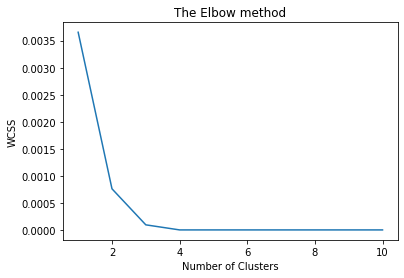

In [213]:
# function returns WSS score for k values from 1 to kmax
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(denver_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

The above graph indicates the optimal number of centroids needed to perform k-means clustering is 3.

Run k-means clustering on the neighborhoods in Denver, CO.

In [214]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(denver_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [215]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
denver_merged = denver_theater.copy()

# add clustering labels
denver_merged["Cluster Labels"] = kmeans.labels_

In [216]:
denver_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
denver_merged.head()

,Neighborhood,Movie Theater,Cluster Labels
0,"Alamo Placita, Denver",0.0,0
1,"Athmar Park, Denver",0.0,0
2,"Auraria, Denver",0.0,0
3,"Baker, Denver",0.0,0
4,"Barnum, Denver",0.0,0


In [217]:
# merge denver_merged with denver_df to add latitude/longitude for each neighborhood
denver_merged = denver_merged.join(denver_df.set_index("Neighborhood"), on="Neighborhood")

print(denver_merged.shape)
denver_merged.head() # check the last columns!

(51, 5)


,Neighborhood,Movie Theater,Cluster Labels,Latitude,Longitude
0,"Alamo Placita, Denver",0.0,0,39.72107,-104.97522
1,"Athmar Park, Denver",0.0,0,39.70396,-105.01039
2,"Auraria, Denver",0.0,0,39.74575,-105.00997
3,"Baker, Denver",0.0,0,39.71117,-104.99209
4,"Barnum, Denver",0.0,0,39.71816,-105.03262


In [218]:
# sort the results by Cluster Labels
print(denver_merged.shape)
denver_merged.sort_values(["Cluster Labels"], inplace=True)
denver_merged

(51, 5)


,Neighborhood,Movie Theater,Cluster Labels,Latitude,Longitude
0,"Alamo Placita, Denver",0.000000,0,39.721070,-104.975220
27,"Jefferson Park, Denver",0.000000,0,39.751210,-105.021350
28,"Lincoln Park, Denver",0.000000,0,39.728960,-105.002220
29,"LoDo, Denver",0.000000,0,39.752610,-104.999510
30,"Lowry, Denver",0.000000,0,39.716238,-104.908083
31,"Montbello, Denver",0.000000,0,39.793210,-104.833860
32,"Montclair, Denver",0.000000,0,39.731660,-104.913370
34,"Park Hill, Denver",0.000000,0,39.743784,-104.973379
35,"Regis, Denver",0.000000,0,39.787420,-105.040990
36,"Ruby Hill, Denver",0.000000,0,39.691060,-105.008740


**Visualize Clusters**

In [219]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(denver_merged['Latitude'], denver_merged['Longitude'], denver_merged['Neighborhood'], denver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [220]:
# save the map as HTML file
map_clusters.save('map_clusters.html')

### 8. Examine Clusters

#### Cluster 0

In [221]:
denver_merged.loc[denver_merged['Cluster Labels'] == 0]

,Neighborhood,Movie Theater,Cluster Labels,Latitude,Longitude
0,"Alamo Placita, Denver",0.0,0,39.721070,-104.975220
27,"Jefferson Park, Denver",0.0,0,39.751210,-105.021350
28,"Lincoln Park, Denver",0.0,0,39.728960,-105.002220
29,"LoDo, Denver",0.0,0,39.752610,-104.999510
30,"Lowry, Denver",0.0,0,39.716238,-104.908083
31,"Montbello, Denver",0.0,0,39.793210,-104.833860
32,"Montclair, Denver",0.0,0,39.731660,-104.913370
34,"Park Hill, Denver",0.0,0,39.743784,-104.973379
35,"Regis, Denver",0.0,0,39.787420,-105.040990
36,"Ruby Hill, Denver",0.0,0,39.691060,-105.008740


#### Cluster 1

In [222]:
denver_merged.loc[denver_merged['Cluster Labels'] == 1]

,Neighborhood,Movie Theater,Cluster Labels,Latitude,Longitude
49,"West Colfax, Denver",0.055556,1,39.74035,-105.04144


#### Cluster 2

In [223]:
denver_merged.loc[denver_merged['Cluster Labels'] == 2]

,Neighborhood,Movie Theater,Cluster Labels,Latitude,Longitude
15,"Civic Center, Denver (neighborhood)",0.010000,2,39.73526,-104.99058
33,"North Capitol Hill, Denver",0.010000,2,39.74425,-104.98108
18,"Congress Park, Denver",0.020833,2,39.73359,-104.95001
14,"City Park, Denver",0.010000,2,39.74379,-104.94825
12,"Chinatown, Denver",0.010000,2,39.74001,-104.99202


#### Summary:

After reviewing the map of movie theaters in Denver, the majority of them are clustered around central denver represented by Cluster 2. Cluster 1 represents the highest concentration of movie theaters. Therefore, Neighborhoods in Cluster 1 and 2 are not viable for new movie theaters as they already have a higher concentration than cluster 0.

There are many opportunities for opening a movie theater in Cluster 0 neighborhoods. Cluster 0 has very few to no movie theaters. However, The suburbs in Cluster 0 may not be ideal for high traffic shopping centers. However, there are neighborhoods, such as those in Northern Denver near I-70 which are high traffic areas that are not in residential areas. These areas have very little competition and present the most opportunity for building a new movie theater.